In [2]:
import sys
sys.path.append('../..')
from utilities.get_data import get_historical_from_db
import pandas as pd
import ccxt
import matplotlib.pyplot as plt
import ta

In [3]:
# --- Load Data ---
pair = "BTC/USDT"
tf = "1h"

df = get_historical_from_db(ccxt.binance(),pair,tf,path="../../database/")
df

,open,high,low,close,volume
date,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916
2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691
2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807
...,...,...,...,...,...
2022-04-30 12:00:00,38580.00,38610.00,38525.34,38536.23,767.521980
2022-04-30 13:00:00,38536.23,38638.24,38501.00,38506.33,1275.793990
2022-04-30 14:00:00,38506.32,38638.38,38211.00,38258.27,4427.800480


In [4]:
#Exponential Moving Average
df['EMA1']=ta.trend.ema_indicator(close=df['close'], window=7)
df['EMA2']=ta.trend.ema_indicator(close=df['close'], window=30)
df['EMA3']=ta.trend.ema_indicator(close=df['close'], window=50)
df['EMA4']=ta.trend.ema_indicator(close=df['close'], window=100)
df['EMA5']=ta.trend.ema_indicator(close=df['close'], window=121)
df['EMA6']=ta.trend.ema_indicator(close=df['close'], window=200)

# #Stochastic RSI
df['STOCH_RSI'] = ta.momentum.stochrsi(close=df['close'], window=14, smooth1=3, smooth2=3)

# #Average True Range (ATR)
df['ATR'] = ta.volatility.average_true_range(high=df['high'], low=df['low'], close=df['close'], window=14)

Period : [2017-08-17 04:00:00] -> [2022-04-30 16:00:00]
Starting balance : 1000 $
Final balance : 26256.67 $
Performance vs US Dollar : 2525.67 %
Buy and Hold Performence : 794.91 %
Performance vs Buy and Hold : 217.73 %
Number of negative trades :  72
Number of positive trades :  43
Average Positive Trades :  15.94 %
Average Negative Trades :  -3.13 %
Best trade +128.81 %, the  2017-12-19 21:00:00
Worst trade -9.43 %, the  2021-01-15 20:00:00
Worst drawBack -32.0 %
Total fee :  2224.79 $
Buy Market number : 115
Sell Market number : 115
PLOT


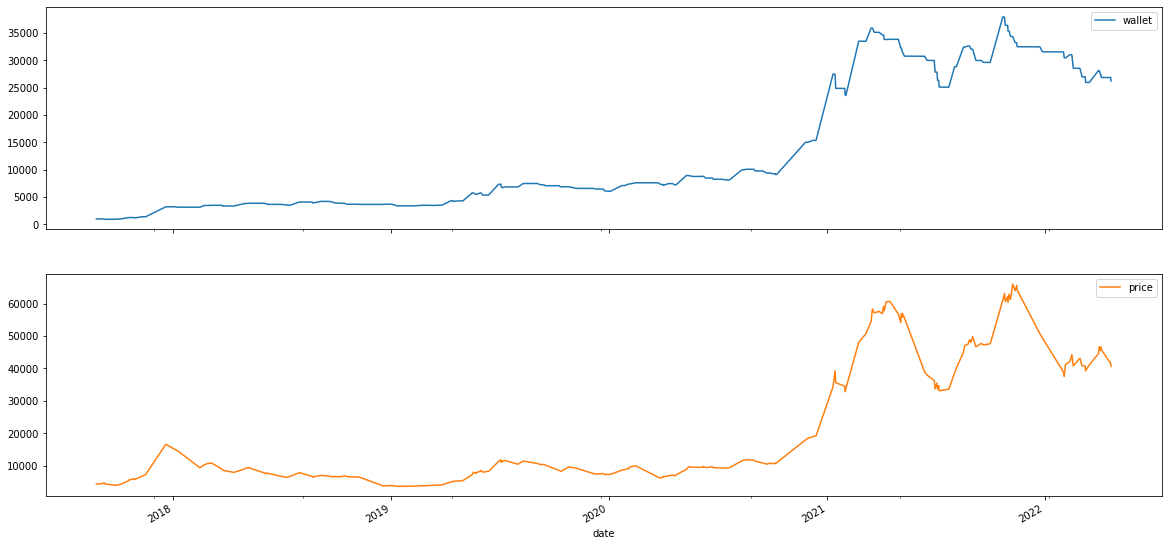

In [5]:
dfTest = df.copy()
# dfTest = df['2021-01-01':]
dt = None
dt = pd.DataFrame(columns = ['date','position', 'reason', 'price', 'frais' ,'fiat', 'coins', 'wallet', 'drawBack'])

usdt = 1000
initalWallet = usdt
coin = 0
wallet = 1000
lastAth = 0
previousRow = dfTest.iloc[0]
makerFee = 0.0003
takerFee = 0.0007
stopLoss = 0
takeProfit = 500000
buyReady = True
sellReady = True

def buyCondition(row, previousRow):
  if row['EMA1'] > row['EMA2'] and row['EMA2'] > row['EMA3'] and row['EMA3'] > row['EMA4'] and row['EMA4'] > row['EMA5'] and row['EMA5'] > row['EMA6'] and row['STOCH_RSI']<0.82:
    return True
  else:
    return False

  
def sellCondition(row, previousRow):
  if row['EMA6'] > row['EMA1'] and row['STOCH_RSI']>0.2:
    return True
  else:
    return False


for index, row in dfTest.iterrows():
  #Buy market order
  if buyCondition(row, previousRow) == True and usdt > 0 and buyReady == True:
    #You can define here at what price you buy
    buyPrice = row['close']

    #Define the price of you SL and TP or comment it if you don't want a SL or TP
    # stopLoss = buyPrice - 2 * row['ATR']
    # takeProfit = buyPrice + 4 * row['ATR']

    coin = usdt / buyPrice
    fee = takerFee * coin
    coin = coin - fee
    usdt = 0
    wallet = coin * row['close']
    if wallet > lastAth:
      lastAth = wallet

    # print("Buy COIN at",buyPrice,'$ the', index)
    myrow = {'date': index,'position': "Buy", 'reason': 'Buy Market','price': buyPrice,'frais': fee*row['close'],'fiat': usdt,'coins': coin,'wallet': wallet,'drawBack':(wallet-lastAth)/lastAth}
    dt = dt.append(myrow,ignore_index=True)
  
  #Stop Loss
  elif row['low'] < stopLoss and coin > 0:

    sellPrice = stopLoss

    usdt = coin * sellPrice
    fee = makerFee * usdt
    usdt = usdt - fee
    coin = 0
    buyReady = False
    wallet = usdt
    if wallet > lastAth:
      lastAth = wallet
    # print("Sell COIN at Stop Loss",sellPrice,'$ the', index)
    myrow = {'date': index,'position': "Sell", 'reason': 'Sell Stop Loss', 'price': sellPrice, 'frais': fee, 'fiat': usdt, 'coins': coin, 'wallet': wallet, 'drawBack':(wallet-lastAth)/lastAth}
    dt = dt.append(myrow,ignore_index=True)

  #Take Profit
  elif row['high'] > takeProfit and coin > 0:

    sellPrice = takeProfit

    usdt = coin * sellPrice
    fee = makerFee * usdt
    usdt = usdt - fee
    coin = 0
    buyReady = False
    wallet = usdt
    if wallet > lastAth:
      lastAth = wallet
    # print("Sell COIN at Take Profit Loss",sellPrice,'$ the', index)
    myrow = {'date': index,'position': "Sell", 'reason': 'Sell Take Profit', 'price': sellPrice, 'frais': fee, 'fiat': usdt, 'coins': coin, 'wallet': wallet, 'drawBack':(wallet-lastAth)/lastAth}
    dt = dt.append(myrow,ignore_index=True)     

  # Sell Market
  elif sellCondition(row, previousRow) == True:
    buyReady = True
    if coin > 0 and sellReady == True:
      sellPrice = row['close']
      usdt = coin * sellPrice
      frais = takerFee * usdt
      usdt = usdt - frais
      coin = 0
      wallet = usdt
      if wallet > lastAth:
        lastAth = wallet
      # print("Sell COIN at",sellPrice,'$ the', index)
      myrow = {'date': index,'position': "Sell", 'reason': 'Sell Market', 'price': sellPrice, 'frais': frais, 'fiat': usdt, 'coins': coin, 'wallet': wallet, 'drawBack':(wallet-lastAth)/lastAth}
      dt = dt.append(myrow,ignore_index=True)
  
  previousRow = row

#///////////////////////////////////////
print("Period : [" + str(dfTest.index[0]) + "] -> [" +str(dfTest.index[len(dfTest)-1]) + "]")
dt = dt.set_index(dt['date'])
dt.index = pd.to_datetime(dt.index)
dt['resultat'] = dt['wallet'].diff()
dt['resultat%'] = dt['wallet'].pct_change()*100
dt.loc[dt['position']=='Buy','resultat'] = None
dt.loc[dt['position']=='Buy','resultat%'] = None

dt['tradeIs'] = ''
dt.loc[dt['resultat']>0,'tradeIs'] = 'Good'
dt.loc[dt['resultat']<=0,'tradeIs'] = 'Bad'

iniClose = dfTest.iloc[0]['close']
lastClose = dfTest.iloc[len(dfTest)-1]['close']
holdPorcentage = ((lastClose - iniClose)/iniClose) * 100
algoPorcentage = ((wallet - initalWallet)/initalWallet) * 100
vsHoldPorcentage = ((algoPorcentage - holdPorcentage)/holdPorcentage) * 100

print("Starting balance : 1000 $")
print("Final balance :",round(wallet,2),"$")
print("Performance vs US Dollar :",round(algoPorcentage,2),"%")
print("Buy and Hold Performence :",round(holdPorcentage,2),"%")
print("Performance vs Buy and Hold :",round(vsHoldPorcentage,2),"%")
print("Number of negative trades : ",dt.groupby('tradeIs')['date'].nunique()['Bad'])
print("Number of positive trades : ",dt.groupby('tradeIs')['date'].nunique()['Good'])
print("Average Positive Trades : ",round(dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].sum()/dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].count(),2),"%")
print("Average Negative Trades : ",round(dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].sum()/dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].count(),2),"%")
idbest = dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].idxmax()
idworst = dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].idxmin()
print("Best trade +"+str(round(dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].max(),2)),"%, the ",dt['date'][idbest])
print("Worst trade",round(dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].min(),2),"%, the ",dt['date'][idworst])
print("Worst drawBack", str(100*round(dt['drawBack'].min(),2)),"%")
print("Total fee : ",round(dt['frais'].sum(),2),"$")
reasons = dt['reason'].unique()
for r in reasons:
  print(r+" number :",dt.groupby('reason')['date'].nunique()[r])

dt[['wallet','price']].plot(subplots=True, figsize=(20,10))
print('PLOT')
# dt